In [36]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [41]:
# Heston + Black-Scholes + IV surface
def simulate_heston_paths(
    n_paths=20000,
    T=1.0,
    N=252,
    S0=100.0,
    v0=0.04,
    r=0.01,
    kappa=2.0,
    theta=0.04,
    eta=0.5,
    rho=-0.7,
    seed=None,
):
    rng = np.random.default_rng(seed)
    dt = T / N
    S_paths = np.zeros((n_paths, N + 1), dtype=float)
    X_paths = np.zeros((n_paths, N + 1), dtype=float)
    v_paths = np.zeros((n_paths, N + 1), dtype=float)

    S_paths[:, 0] = S0
    X_paths[:, 0] = np.log(S0)
    v_paths[:, 0] = v0

    for n in range(N):
        v_curr = np.maximum(v_paths[:, n], 1e-8)
        X_curr = X_paths[:, n]

        z1 = rng.normal(0.0, 1.0, size=n_paths)
        z2 = rng.normal(0.0, 1.0, size=n_paths)
        dB1 = math.sqrt(dt) * z1
        dB2 = math.sqrt(dt) * z2

        dW1 = dB1
        dW2 = rho * dB1 + math.sqrt(1.0 - rho**2) * dB2

        dX = (r - 0.5 * v_curr) * dt + np.sqrt(v_curr) * dW1
        dv = kappa * (theta - v_curr) * dt + eta * np.sqrt(v_curr) * dW2

        X_next = X_curr + dX
        v_next = np.maximum(v_curr + dv, 1e-8)

        X_paths[:, n+1] = X_next
        v_paths[:, n+1] = v_next
        S_paths[:, n+1] = np.exp(X_next)

    return S_paths


def bs_call_price(S, K, r, sigma, T):
    if sigma <= 0 or T <= 0:
        return max(S - K * math.exp(-r * T), 0.0)
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    from math import erf
    def norm_cdf(x):
        return 0.5 * (1.0 + erf(x / math.sqrt(2.0)))
    return S * norm_cdf(d1) - K * math.exp(-r * T) * norm_cdf(d2)


def implied_vol_bisection(price, S, K, r, T,
                          low=1e-4, high=3.0, tol=1e-6, max_iter=100):
    intrinsic = max(S - K * math.exp(-r*T), 0.0)
    if price <= intrinsic + 1e-6:
        return 0.0
    for _ in range(max_iter):
        mid = 0.5 * (low + high)
        c = bs_call_price(S, K, r, mid, T)
        if abs(c - price) < tol:
            return mid
        if c > price:
            high = mid
        else:
            low = mid
    return mid


def mc_call_prices_from_paths(S_paths, T_list, K_list, r, T_total):
    n_paths, N_plus = S_paths.shape
    N = N_plus - 1
    dt = T_total / N
    prices = {}
    for T in T_list:
        idx = min(int(round(T / dt)), N)
        S_T = S_paths[:, idx]
        for K in K_list:
            payoff = np.maximum(S_T - K, 0.0)
            price = math.exp(-r * T) * payoff.mean()
            prices[(T, K)] = price
    return prices


def compute_iv_surface(S_paths, S0, T_list, K_list, r, T_total):
    prices = mc_call_prices_from_paths(S_paths, T_list, K_list, r, T_total)
    H, W = len(T_list), len(K_list)
    iv = np.zeros((H, W), dtype=float)
    for i, T in enumerate(T_list):
        for j, K in enumerate(K_list):
            c = prices[(T, K)]
            iv[i, j] = implied_vol_bisection(c, S0, K, r, T)
    return iv



def smooth_surfaces_with_quadratic_smile(
    total_var: np.ndarray,
    maturities: np.ndarray,
    K_list: np.ndarray,
    S0: float,
    min_iv: float = 0.05,
    max_iv: float = 1.0,
    invalid_iv_thresh: float = 1e-3,
) -> np.ndarray:
    N, H, W = total_var.shape
    T_arr = np.asarray(maturities, dtype=float)
    K_arr = np.asarray(K_list, dtype=float)
    M_arr = K_arr / float(S0)                # moneyness
    x_all = np.log(M_arr)                    # log-moneyness

    w_smooth = np.zeros_like(total_var, dtype=float)

    for n in range(N):
        for ti in range(H):
            T_val = float(T_arr[ti])
            w_row = total_var[n, ti, :]      # (W,)

            w_clipped = np.clip(w_row, 0.0, None)

            if T_val <= 0:
                w_smooth[n, ti, :] = w_clipped
                continue

            sigma_row = np.sqrt(w_clipped / T_val)  # (W,)
            mask_valid = sigma_row > invalid_iv_thresh

            if mask_valid.sum() < 4:
                w_smooth[n, ti, :] = w_clipped
                continue

            x_valid = x_all[mask_valid]
            y_valid = sigma_row[mask_valid]

            coeffs = np.polyfit(x_valid, y_valid, deg=2)
            sigma_fit = np.polyval(coeffs, x_all)

            sigma_fit = np.clip(sigma_fit, min_iv, max_iv)

            w_smooth[n, ti, :] = (sigma_fit ** 2) * T_val

    return w_smooth


class IVSurfaceDataset(Dataset):
    def __init__(self, n_samples=200, S0=100.0, r=0.01,
                 T_list=None, K_list=None,
                 T_total=1.0, n_paths_mc=2000, seed=0):

        if T_list is None:
            T_list = [0.25, 0.5, 1.0]
        if K_list is None:
            K_list = np.linspace(70, 130, 13)

        self.T_list = np.array(T_list, dtype=float)
        self.K_list = np.array(K_list, dtype=float)
        self.S0 = float(S0)

        rng = np.random.default_rng(seed)
        surfaces = []

        base_kappa = 2.0
        base_theta = 0.04
        base_eta   = 0.5
        base_rho   = -0.7
        base_v0    = 0.04

        print("Generating IV surface dataset...")
        for i in range(n_samples):
            kappa = base_kappa * (0.8 + 0.4 * rng.random())
            theta = base_theta * (0.7 + 0.6 * rng.random())
            eta   = base_eta   * (0.7 + 0.6 * rng.random())
            rho   = base_rho + 0.1 * rng.normal()
            rho   = float(np.clip(rho, -0.95, -0.05))
            v0    = base_v0 * (0.7 + 0.6 * rng.random())

            S_paths = simulate_heston_paths(
                n_paths=n_paths_mc, T=T_total, N=252,
                S0=S0, v0=v0, r=r,
                kappa=kappa, theta=theta, eta=eta, rho=rho,
                seed=rng.integers(0, 10_000_000)
            )
            iv = compute_iv_surface(S_paths, S0, self.T_list, self.K_list, r, T_total)
            surfaces.append(iv)

            if (i+1) % 20 == 0:
                print(f"  generated {i+1}/{n_samples} surfaces")

        surfaces = np.array(surfaces)  # (N,H,W)
        tau = self.T_list.reshape(1, len(self.T_list), 1)
        total_var = (surfaces ** 2) * tau  # (N,H,W)

        total_var = smooth_surfaces_with_quadratic_smile(
            total_var,
            maturities=self.T_list,
            K_list=self.K_list,
            S0=S0,
            min_iv=0.05,
            max_iv=1.0,
            invalid_iv_thresh=1e-3,
        )

        self.mean = float(total_var.mean())
        self.std  = float(total_var.std() + 1e-8)
        total_var_norm = (total_var - self.mean) / self.std

        self.data = torch.from_numpy(total_var_norm.astype(np.float32)).unsqueeze(1)

        print("Dataset shape:", self.data.shape)
        print("Normalized mean/std:", self.data.mean().item(), self.data.std().item())

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

class DiffusionConfig:
    def __init__(self, timesteps=200, beta_start=1e-4, beta_end=0.02):
        self.T = timesteps
        betas = torch.linspace(beta_start, beta_end, timesteps)
        self.betas = betas.to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)


def extract(a, t, x_shape):
    out = a[t]  # (B,)
    return out.view(-1, *([1] * (len(x_shape) - 1)))


def sinusoidal_embedding(timesteps, dim):
    device_ = timesteps.device
    half_dim = dim // 2
    freqs = torch.exp(
        -math.log(10000.0)
        * torch.arange(0, half_dim, device=device_).float()
        / half_dim
    )
    args = timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0,1))
    return emb


class TimeEmbedding(nn.Module):
    def __init__(self, dim, out_dim):
        super().__init__()
        self.linear1 = nn.Linear(dim, out_dim)
        self.act = nn.SiLU()
        self.linear2 = nn.Linear(out_dim, out_dim)

    def forward(self, t):
        emb = sinusoidal_embedding(t, self.linear1.in_features)
        emb = self.linear1(emb)
        emb = self.act(emb)
        emb = self.linear2(emb)
        return emb


class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.act   = nn.SiLU()
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)

        self.shortcut = (
            nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        )

    def forward(self, x, t_emb):
        h = self.conv1(x)
        t_add = self.time_mlp(t_emb)
        h = h + t_add[:, :, None, None]
        h = self.act(self.norm1(h))
        h = self.conv2(h)
        h = self.act(self.norm2(h))
        return h + self.shortcut(x)


class UNet2D(nn.Module):
    def __init__(self, in_ch=1, base_ch=64, time_emb_dim=128):
        super().__init__()
        self.time_embed = TimeEmbedding(dim=32, out_dim=time_emb_dim)

        self.enc_block1 = ResBlock(in_ch, base_ch, time_emb_dim)
        self.down1 = nn.Conv2d(base_ch, base_ch, 3, stride=2, padding=1)

        self.enc_block2 = ResBlock(base_ch, base_ch*2, time_emb_dim)
        self.down2 = nn.Conv2d(base_ch*2, base_ch*2, 3, stride=2, padding=1)

        self.enc_block3 = ResBlock(base_ch*2, base_ch*4, time_emb_dim)

        self.mid_block1 = ResBlock(base_ch*4, base_ch*4, time_emb_dim)

        self.up1 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 4, stride=2, padding=1)
        self.dec_block1 = ResBlock(base_ch*4, base_ch*2, time_emb_dim)

        self.up2 = nn.ConvTranspose2d(base_ch*2, base_ch, 4, stride=2, padding=1)
        self.dec_block2 = ResBlock(base_ch*2, base_ch, time_emb_dim)

        self.out_conv = nn.Conv2d(base_ch, in_ch, 1)

    def forward(self, x, t):
        t_emb = self.time_embed(t)

        h1 = self.enc_block1(x, t_emb)
        h  = self.down1(h1)

        h2 = self.enc_block2(h, t_emb)
        h  = self.down2(h2)

        h3 = self.enc_block3(h, t_emb)

        h = self.mid_block1(h3, t_emb)

        h = self.up1(h)
        if h.shape[2:] != h2.shape[2:]:
            h = F.interpolate(h, size=h2.shape[2:], mode="nearest")
        h = torch.cat([h, h2], dim=1)
        h = self.dec_block1(h, t_emb)

        h = self.up2(h)
        if h.shape[2:] != h1.shape[2:]:
            h = F.interpolate(h, size=h1.shape[2:], mode="nearest")
        h = torch.cat([h, h1], dim=1)
        h = self.dec_block2(h, t_emb)

        return self.out_conv(h)



def train_diffusion_model(
    dataset,
    diffusion_config,
    num_epochs=40,
    batch_size=16,
    lr=1e-4,
):
    model = UNet2D(in_ch=1, base_ch=64, time_emb_dim=128).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    T = diffusion_config.T
    alpha_bars = diffusion_config.alpha_bars

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        count = 0
        for x0 in loader:
            x0 = x0.to(device)
            B = x0.shape[0]
            t = torch.randint(0, T, (B,), device=device)

            eps = torch.randn_like(x0)
            alpha_bar_t = extract(alpha_bars, t, x0.shape)
            x_t = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * eps

            eps_hat = model(x_t, t)
            loss = F.mse_loss(eps_hat, eps)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * B
            count += B

        print(f"Epoch {epoch+1}/{num_epochs}, loss = {running_loss / count:.6f}")

    return model


@torch.no_grad()
def sample_surfaces(model, diffusion_config, n_samples, img_shape):
    model.eval()
    T = diffusion_config.T
    betas = diffusion_config.betas
    alphas = diffusion_config.alphas
    alpha_bars = diffusion_config.alpha_bars

    C, H, W = img_shape
    x = torch.randn(n_samples, C, H, W, device=device)

    for t_step in reversed(range(T)):
        t = torch.full((n_samples,), t_step, device=device, dtype=torch.long)
        eps_theta = model(x, t)

        beta_t = extract(betas, t, x.shape)
        alpha_t = extract(alphas, t, x.shape)
        alpha_bar_t = extract(alpha_bars, t, x.shape)
        if t_step > 0:
            t_prev = t - 1
            alpha_bar_prev = extract(alpha_bars, t_prev, x.shape)
        else:
            alpha_bar_prev = torch.ones_like(alpha_bar_t)

        coef1 = 1.0 / torch.sqrt(alpha_t)
        coef2 = beta_t / torch.sqrt(1.0 - alpha_bar_t)
        mean = coef1 * (x - coef2 * eps_theta)

        if t_step > 0:
            beta_tilde = (1.0 - alpha_bar_prev) / (1.0 - alpha_bar_t) * beta_t
            noise = torch.randn_like(x)
            x = mean + torch.sqrt(beta_tilde) * noise
        else:
            x = mean

    return x  # (n_samples,C,H,W)


@torch.no_grad()
def sample_surface_trajectory(model, diffusion_config, img_shape,
                              save_steps=(0, 1, 5, 50, 100, 150, 199)):
    model.eval()
    T = diffusion_config.T
    betas = diffusion_config.betas
    alphas = diffusion_config.alphas
    alpha_bars = diffusion_config.alpha_bars

    C, H, W = img_shape
    x = torch.randn(1, C, H, W, device=device)

    save_set = set(save_steps)
    snapshots = {}

    for t_step in reversed(range(T)):
        t = torch.full((1,), t_step, device=device, dtype=torch.long)
        eps_theta = model(x, t)

        beta_t = extract(betas, t, x.shape)
        alpha_t = extract(alphas, t, x.shape)
        alpha_bar_t = extract(alpha_bars, t, x.shape)
        if t_step > 0:
            t_prev = t - 1
            alpha_bar_prev = extract(alpha_bars, t_prev, x.shape)
        else:
            alpha_bar_prev = torch.ones_like(alpha_bar_t)

        coef1 = 1.0 / torch.sqrt(alpha_t)
        coef2 = beta_t / torch.sqrt(1.0 - alpha_bar_t)
        mean = coef1 * (x - coef2 * eps_theta)

        if t_step > 0:
            beta_tilde = (1.0 - alpha_bar_prev) / (1.0 - alpha_bar_t) * beta_t
            noise = torch.randn_like(x)
            x = mean + torch.sqrt(beta_tilde) * noise
        else:
            x = mean

        if t_step in save_set:
            snapshots[t_step] = x[0,0].detach().cpu().numpy()

    return snapshots


def evaluate_surfaces(dataset, T_list, K_list, gen_sigma, S0=100.0, r=0.01, tol_calendar=1e-6):
    print("\n===== Evaluation: real vs generated IV surfaces =====")

    real_tv_norm = dataset.data.numpy()[:, 0, :, :]
    H = len(T_list)
    W = len(K_list)
    tau = np.array(T_list).reshape(1, H, 1)
    real_tv = real_tv_norm * dataset.std + dataset.mean
    sigma_real = np.sqrt(np.maximum(real_tv / tau, 1e-8))

    sigma_gen = gen_sigma
    N_real = sigma_real.shape[0]
    N_gen  = sigma_gen.shape[0]

    k_atm_idx = int(np.argmin(np.abs(K_list - S0)))
    real_atm = sigma_real[:, :, k_atm_idx]
    gen_atm  = sigma_gen[:, :, k_atm_idx]

    print("\n[ATM vol stats]")
    for i, T in enumerate(T_list):
        mu_r = real_atm[:, i].mean()
        std_r = real_atm[:, i].std()
        mu_g = gen_atm[:, i].mean()
        std_g = gen_atm[:, i].std()
        print(f"T={T:.2f}  real mean/std={mu_r:.4f}/{std_r:.4f},  gen mean/std={mu_g:.4f}/{std_g:.4f}")

    real_skew = sigma_real[:, :, 0] - sigma_real[:, :, -1]
    gen_skew  = sigma_gen[:, :, 0]   - sigma_gen[:, :, -1]

    print("\n[Skew stats: sigma(T,K_min) - sigma(T,K_max)]")
    for i, T in enumerate(T_list):
        mu_r = real_skew[:, i].mean()
        std_r = real_skew[:, i].std()
        mu_g = gen_skew[:, i].mean()
        std_g = gen_skew[:, i].std()
        print(f"T={T:.2f}  real mean/std={mu_r:.4f}/{std_r:.4f},  gen mean/std={mu_g:.4f}/{std_g:.4f}")

    def butterfly_violation_ratio(sigma_arr):
        N, H_, W_ = sigma_arr.shape
        neg = 0
        tot = 0
        dK = K_list[1] - K_list[0]
        for n in range(N):
            for i, T in enumerate(T_list):
                for j in range(1, W_-1):
                    C_m = bs_call_price(S0, K_list[j-1], r, sigma_arr[n,i,j-1], T)
                    C_0 = bs_call_price(S0, K_list[j],   r, sigma_arr[n,i,j],   T)
                    C_p = bs_call_price(S0, K_list[j+1], r, sigma_arr[n,i,j+1], T)
                    second = (C_m - 2*C_0 + C_p) / (dK**2)
                    if second < 0:
                        neg += 1
                    tot += 1
        return neg / tot if tot > 0 else 0.0

    real_bfly = butterfly_violation_ratio(sigma_real)
    gen_bfly  = butterfly_violation_ratio(sigma_gen)
    print(f"\n[Butterfly arbitrage violation ratio]")
    print(f"real: {real_bfly:.4%},  gen: {gen_bfly:.4%}")

    def calendar_violation_ratio(sigma_arr, tol=tol_calendar):
        N, H_, W_ = sigma_arr.shape
        neg = 0
        tot = 0
        tau_vec = np.array(T_list)
        for n in range(N):
            for j in range(W_):
                for i in range(H_-1):
                    w_i = sigma_arr[n,i,j]**2 * tau_vec[i]
                    w_next = sigma_arr[n,i+1,j]**2 * tau_vec[i+1]
                    if w_next + tol < w_i:
                        neg += 1
                    tot += 1
        return neg / tot if tot > 0 else 0.0

    real_cal = calendar_violation_ratio(sigma_real)
    gen_cal  = calendar_violation_ratio(sigma_gen)
    print(f"\n[Calendar arbitrage violation ratio]")
    print(f"real: {real_cal:.4%},  gen: {gen_cal:.4%}\n")

def plot_iv_surface_3d(T_list, K_list, sigma_surface, S0=100.0, title="IV surface 3D"):
    sigma_surface = np.asarray(sigma_surface)
    T_arr = np.asarray(T_list)
    K_arr = np.asarray(K_list)
    M_arr = K_arr / float(S0)

    T_grid, M_grid = np.meshgrid(T_arr, M_arr, indexing="ij")

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, projection="3d")

    surf = ax.plot_surface(
        T_grid, M_grid, sigma_surface,
        cmap=cm.viridis,
        linewidth=0,
        antialiased=True,
    )
    ax.set_ylim(ax.get_ylim()[::-1])

    ax.set_xlabel("TTM (T)")
    ax.set_ylabel("Moneyness K/S0")
    ax.set_zlabel("Implied vol")
    ax.set_title(title)
    ax.view_init(elev=25, azim=-135)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.tight_layout()
    plt.show()


def surface_evolution_3d(dataset, diff_cfg, model, T_list, K_list,
                         S0=100.0,
                         t_list=(0, 1, 5, 50, 100, 150, 199)):

    H = len(T_list)
    W = len(K_list)

    snapshots = sample_surface_trajectory(
        model, diff_cfg, img_shape=(1, H, W),
        save_steps=t_list
    )

    T_arr = np.array(T_list)
    K_arr = np.array(K_list)
    M_arr = K_arr / float(S0)
    T_grid, M_grid = np.meshgrid(T_arr, M_arr, indexing="ij")

    n_plots = len(t_list)
    n_rows = 2
    n_cols = int(np.ceil(n_plots / n_rows))

    fig = plt.figure(figsize=(4*n_cols, 4*n_rows))

    tau_vec = T_arr.reshape(H, 1)

    for idx, t_step in enumerate(sorted(t_list)):
        ax = fig.add_subplot(n_rows, n_cols, idx+1, projection="3d")
        tv_norm = snapshots[t_step]
        tv = tv_norm * dataset.std + dataset.mean
        sigma = np.sqrt(np.maximum(tv / tau_vec, 1e-8))

        surf = ax.plot_surface(
            T_grid, M_grid, sigma,
            cmap=cm.viridis,
            linewidth=0,
            antialiased=True,
        )
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.set_xlabel("TTM")
        ax.set_ylabel("Moneyness")
        ax.set_zlabel("IV")
        ax.set_title(f"t = {t_step}", pad=0)
        ax.view_init(elev=25, azim=-135)

    plt.suptitle("Surface Evolution at Different Timesteps", y=1.02)
    plt.tight_layout(h_pad=2.0)

    plt.tight_layout()
    plt.show()

def plot_real_vs_generated_pairs_3d(dataset, gen_sigma, T_list, K_list,
                                    S0=100.0, n_pairs=4, seed=0):

    rng = np.random.default_rng(seed)

    H = len(T_list)
    T_arr = np.asarray(T_list)
    K_arr = np.asarray(K_list)
    M_arr = K_arr / float(S0)
    T_grid, M_grid = np.meshgrid(T_arr, M_arr, indexing="ij")

    real_tv_norm = dataset.data.numpy()[:, 0, :, :]
    tau_vec = T_arr.reshape(H, 1)
    real_tv = real_tv_norm * dataset.std + dataset.mean
    sigma_real = np.sqrt(np.maximum(real_tv / tau_vec, 1e-8))

    N_real = sigma_real.shape[0]
    N_gen  = gen_sigma.shape[0]

    n_pairs = min(n_pairs, N_real, N_gen)
    idx = rng.choice(min(N_real, N_gen), size=n_pairs, replace=False)

    fig = plt.figure(figsize=(4 * n_pairs, 7))

    # Real
    for col, i_idx in enumerate(idx):
        ax_real = fig.add_subplot(2, n_pairs, col + 1, projection="3d")
        ax_real.plot_surface(
            T_grid, M_grid, sigma_real[i_idx],
            cmap=cm.viridis, linewidth=0, antialiased=True
        )
        ax_real.set_ylim(ax_real.get_ylim()[::-1])

        ax_real.set_title("Real", pad=2)
        ax_real.set_xlabel("TTM")
        ax_real.set_ylabel("Moneyness K/S0")
        ax_real.set_zlabel("IV")
        ax_real.view_init(elev=25, azim=-135)

    # Generated
    for col, i_idx in enumerate(idx):
        ax_gen = fig.add_subplot(2, n_pairs, n_pairs + col + 1, projection="3d")
        ax_gen.plot_surface(
            T_grid, M_grid, gen_sigma[i_idx],
            cmap=cm.viridis, linewidth=0, antialiased=True
        )
        ax_gen.set_ylim(ax_gen.get_ylim()[::-1])

        ax_gen.set_title("Generated", pad=2)
        ax_gen.set_xlabel("TTM")
        ax_gen.set_ylabel("Moneyness K/S0")
        ax_gen.set_zlabel("IV")
        ax_gen.view_init(elev=25, azim=-135)

    plt.suptitle("Real vs Generated IV surfaces", y=0.96)
    fig.subplots_adjust(hspace=0.45, wspace=0.25)  # ★ 关键：hspace 调大

    plt.show()


Generating IV surface dataset...
  generated 20/200 surfaces
  generated 40/200 surfaces
  generated 60/200 surfaces
  generated 80/200 surfaces
  generated 100/200 surfaces
  generated 120/200 surfaces
  generated 140/200 surfaces
  generated 160/200 surfaces
  generated 180/200 surfaces
  generated 200/200 surfaces
Dataset shape: torch.Size([200, 1, 10, 13])
Normalized mean/std: 3.6679781434401093e-10 1.00001859664917


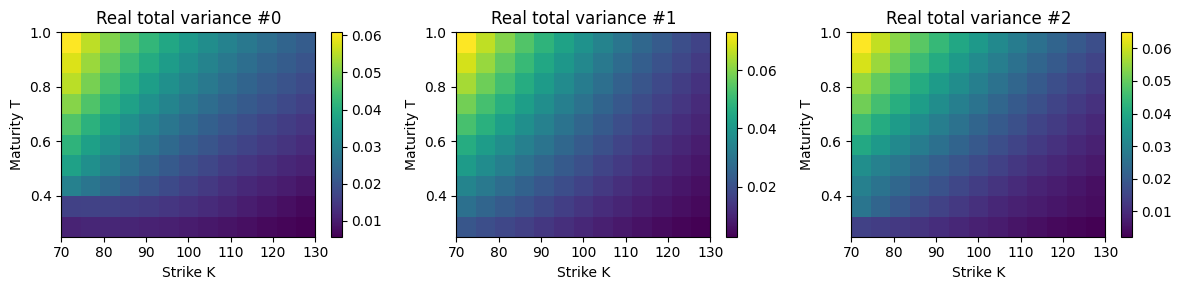

Epoch 1/300, loss = 0.636832
Epoch 2/300, loss = 0.244018
Epoch 3/300, loss = 0.214670
Epoch 4/300, loss = 0.152787
Epoch 5/300, loss = 0.150118
Epoch 6/300, loss = 0.136460
Epoch 7/300, loss = 0.108340
Epoch 8/300, loss = 0.112059
Epoch 9/300, loss = 0.105572
Epoch 10/300, loss = 0.105841
Epoch 11/300, loss = 0.094913
Epoch 12/300, loss = 0.064466
Epoch 13/300, loss = 0.088352
Epoch 14/300, loss = 0.081654
Epoch 15/300, loss = 0.073381
Epoch 16/300, loss = 0.081570
Epoch 17/300, loss = 0.067370
Epoch 18/300, loss = 0.071469
Epoch 19/300, loss = 0.083752
Epoch 20/300, loss = 0.074301
Epoch 21/300, loss = 0.065736
Epoch 22/300, loss = 0.077899
Epoch 23/300, loss = 0.088059
Epoch 24/300, loss = 0.071670
Epoch 25/300, loss = 0.077177
Epoch 26/300, loss = 0.072999
Epoch 27/300, loss = 0.062109
Epoch 28/300, loss = 0.070306
Epoch 29/300, loss = 0.068410
Epoch 30/300, loss = 0.071793
Epoch 31/300, loss = 0.057283
Epoch 32/300, loss = 0.063079
Epoch 33/300, loss = 0.068822
Epoch 34/300, loss 

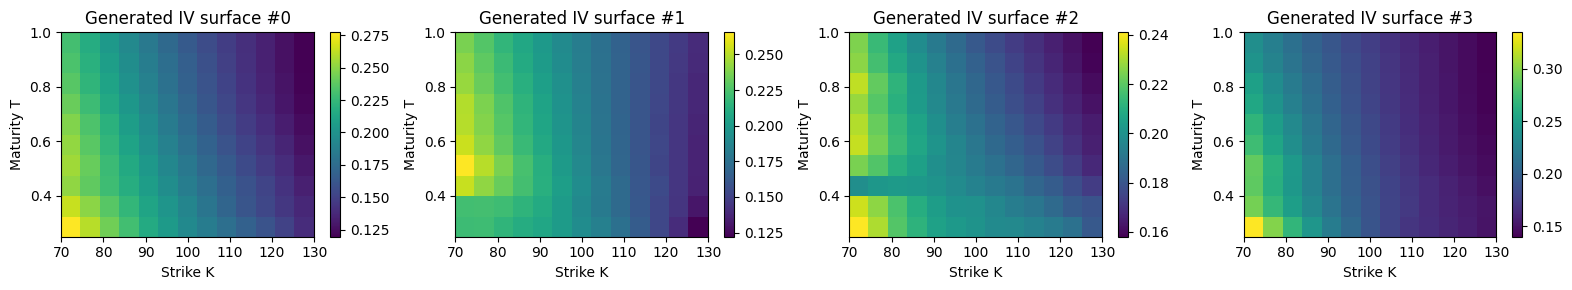

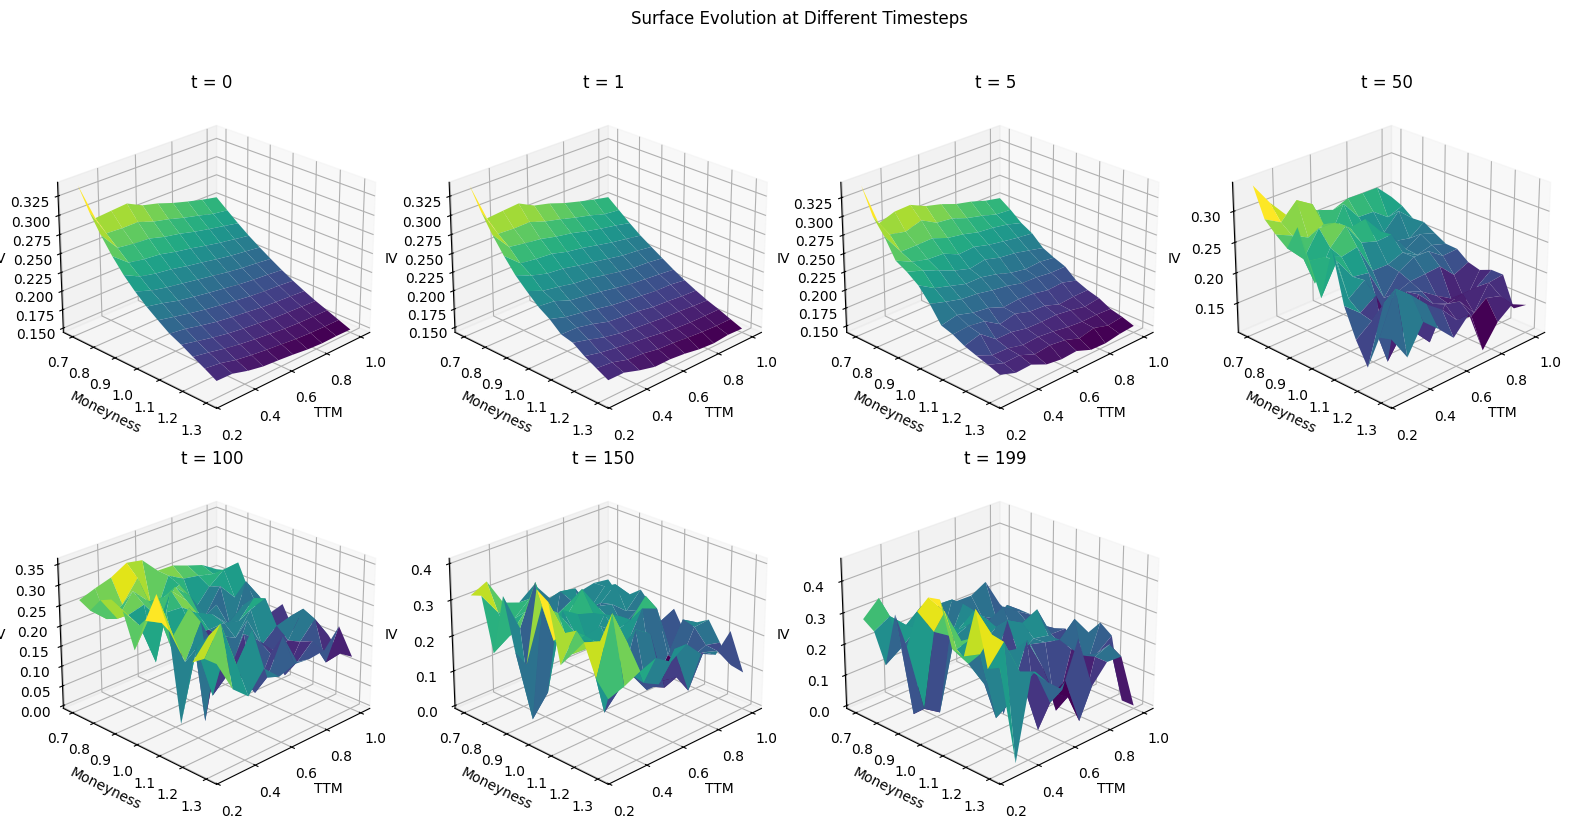

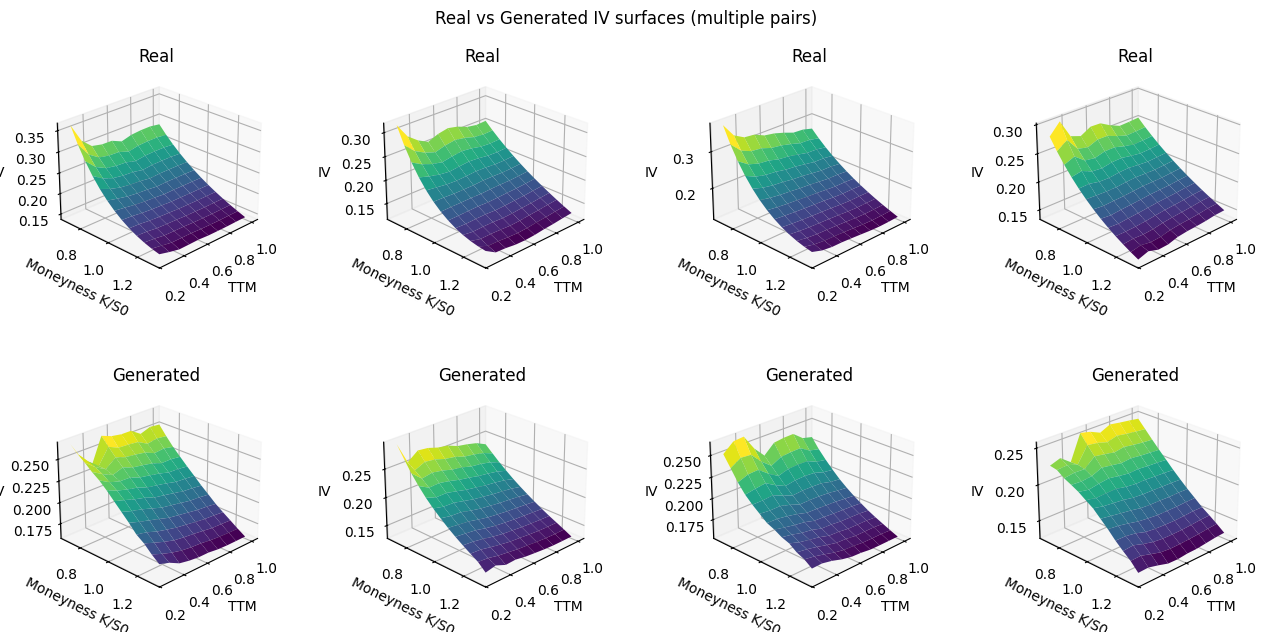


===== Evaluation: real vs generated IV surfaces =====

[ATM vol stats]
T=0.25  real mean/std=0.1905/0.0141,  gen mean/std=0.1995/0.0135
T=0.33  real mean/std=0.1891/0.0136,  gen mean/std=0.1967/0.0127
T=0.42  real mean/std=0.1878/0.0132,  gen mean/std=0.1946/0.0120
T=0.50  real mean/std=0.1866/0.0129,  gen mean/std=0.1915/0.0120
T=0.58  real mean/std=0.1857/0.0129,  gen mean/std=0.1887/0.0120
T=0.67  real mean/std=0.1851/0.0128,  gen mean/std=0.1869/0.0117
T=0.75  real mean/std=0.1846/0.0128,  gen mean/std=0.1851/0.0118
T=0.83  real mean/std=0.1843/0.0127,  gen mean/std=0.1839/0.0117
T=0.92  real mean/std=0.1842/0.0127,  gen mean/std=0.1827/0.0117
T=1.00  real mean/std=0.1841/0.0127,  gen mean/std=0.1812/0.0117

[Skew stats: sigma(T,K_min) - sigma(T,K_max)]
T=0.25  real mean/std=0.1767/0.0480,  gen mean/std=0.1224/0.0406
T=0.33  real mean/std=0.1686/0.0404,  gen mean/std=0.1137/0.0349
T=0.42  real mean/std=0.1618/0.0374,  gen mean/std=0.1069/0.0376
T=0.50  real mean/std=0.1571/0.0339,

In [40]:
S0 = 100.0
r   = 0.01
T_list = np.linspace(0.25, 1.0, 10)
K_list = np.linspace(70, 130, 13)

dataset = IVSurfaceDataset(
    n_samples=200,
    S0=S0,
    r=r,
    T_list=T_list,
    K_list=K_list,
    T_total=1.0,
    n_paths_mc=20000,
    seed=0,
)

H = len(T_list)
W = len(K_list)

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i in range(3):
    tv_norm = dataset[i][0].numpy()
    tv = tv_norm * dataset.std + dataset.mean
    im = axes[i].imshow(
        tv,
        origin="lower",
        extent=[K_list[0], K_list[-1], T_list[0], T_list[-1]],
        aspect="auto",
    )
    axes[i].set_title(f"Real total variance #{i}")
    axes[i].set_xlabel("Strike K")
    axes[i].set_ylabel("Maturity T")
    fig.colorbar(im, ax=axes[i])
plt.tight_layout()
plt.show()

diff_cfg = DiffusionConfig(timesteps=200, beta_start=1e-4, beta_end=0.02)
model = train_diffusion_model(
    dataset,
    diff_cfg,
    num_epochs=300,
    batch_size=16,
    lr=1e-4,
)

n_gen = 64
gen_tv_norm = sample_surfaces(model, diff_cfg, n_gen, img_shape=(1, H, W))
gen_tv_norm = gen_tv_norm.cpu().numpy()

tau = np.array(T_list).reshape(1, H, 1)
gen_tv = gen_tv_norm[:, 0, :, :] * dataset.std + dataset.mean
gen_sigma = np.sqrt(np.maximum(gen_tv / tau, 1e-8))

n_show = 4
fig, axes = plt.subplots(1, n_show, figsize=(4*n_show, 3))
if n_show == 1:
    axes = [axes]
for i in range(n_show):
    im = axes[i].imshow(
        gen_sigma[i],
        origin="lower",
        extent=[K_list[0], K_list[-1], T_list[0], T_list[-1]],
        aspect="auto",
    )
    axes[i].set_title(f"Generated IV surface #{i}")
    axes[i].set_xlabel("Strike K")
    axes[i].set_ylabel("Maturity T")
    fig.colorbar(im, ax=axes[i])
plt.tight_layout()
plt.show()



surface_evolution_3d(
    dataset, diff_cfg, model, T_list, K_list,
    S0=S0,
    t_list=[0, 1, 5, 50, 100, 150, 199]
)

#  real vs generated
plot_real_vs_generated_pairs_3d(
    dataset, gen_sigma, T_list, K_list,
    S0=S0, n_pairs=4, seed=42
)

evaluate_surfaces(dataset, T_list, K_list, gen_sigma, S0=S0, r=r)



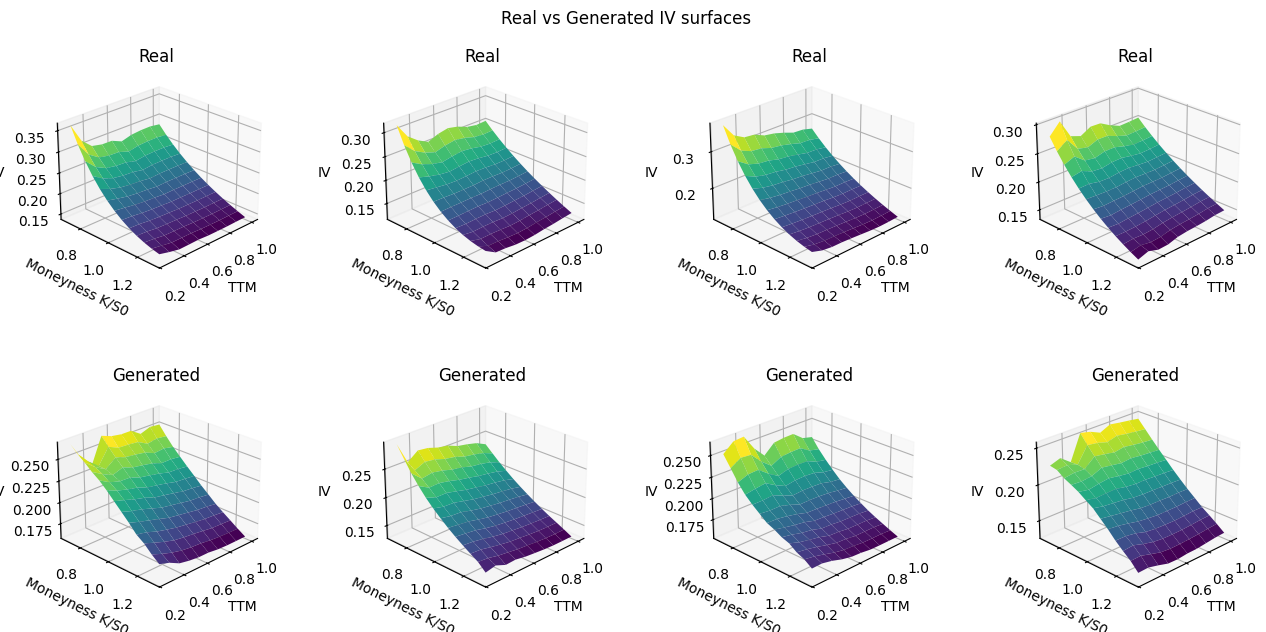

In [42]:
#  real vs generated
plot_real_vs_generated_pairs_3d(
    dataset, gen_sigma, T_list, K_list,
    S0=S0, n_pairs=4, seed=42
)